# 9 Improving performance

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [99]:
X[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

In [6]:
X.shape

(1797, 64)

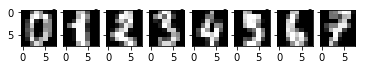

In [7]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [9]:
K.clear_session()

In [10]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
# store the initial random weights
initial_weights = model.get_weights()

In [12]:
y_cat = to_categorical(y, 10)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [15]:
X_train.shape

(1257, 64)

In [16]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [17]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


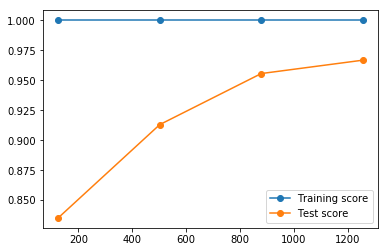

In [18]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [19]:
from keras.layers import BatchNormalization

In [20]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [21]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False, epochs=30)

0 1 2 


In [22]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True, epochs=30)

0 1 2 


In [23]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

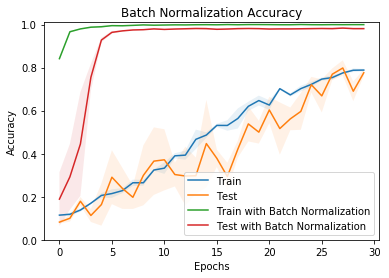

In [24]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


## Weight Regularization & Dropout

In [25]:
from keras.layers import Dropout

In [26]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentation

In [27]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [28]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 1 classes.


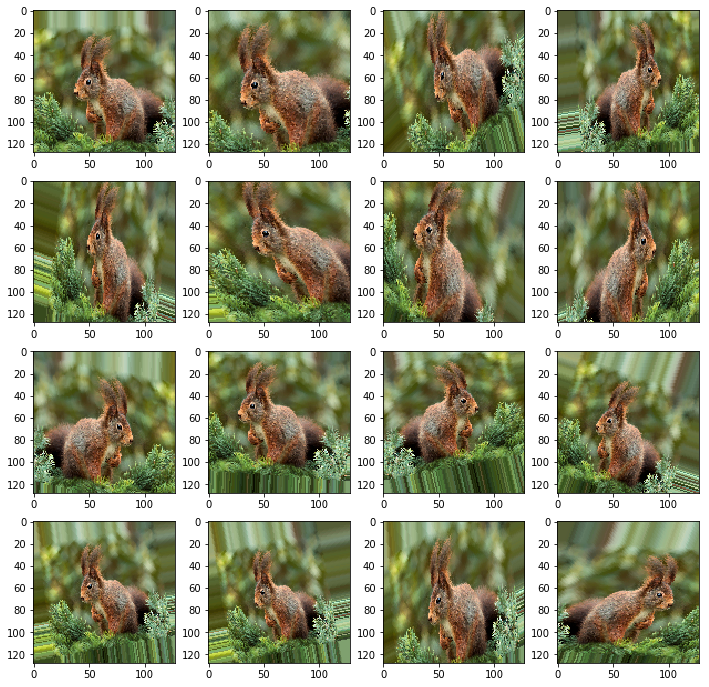

In [29]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

In [30]:
from keras.layers import Embedding

In [31]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [33]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [34]:
emb.shape

(3, 4, 2)

In [35]:
emb

array([[[-0.0238085 , -0.04914343],
        [ 0.03641412, -0.04202265],
        [ 0.04067326, -0.01820772],
        [ 0.02382376, -0.00335461]],

       [[-0.03826135, -0.04985467],
        [-0.04168274, -0.00156677],
        [ 0.02573637,  0.03632111],
        [ 0.0428731 , -0.01142895]],

       [[-0.02859279, -0.01308081],
        [ 0.03487727,  0.0083292 ],
        [ 0.03475806,  0.01565218],
        [-0.00153106,  0.0301085 ]]], dtype=float32)

## Sentiment prediction on movie Reviews

In [36]:
from keras.datasets import imdb

In [37]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [38]:
X_train.shape

(25000,)

In [39]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [40]:
idx = imdb.get_word_index()

In [41]:
max(idx.values())

88584

In [42]:
idx

{'bagatelle': 51365,
 "mode'": 78465,
 'tsanders': 66012,
 'dissapointment': 29030,
 "theatre's": 37246,
 'simulator': 38677,
 'uncalled': 26502,
 'downhill': 4448,
 'gown': 11186,
 'informations': 51837,
 'squealing': 25004,
 'soaps': 13163,
 'plasticized': 63300,
 'senseless': 4268,
 "clockwatchers'": 61675,
 'higly': 81957,
 'skyward': 32067,
 'ganzel': 30691,
 'buddhas': 77911,
 'bigardo': 44002,
 "roof'": 55854,
 "europe'": 43485,
 'woodeness': 61087,
 "com'": 51759,
 'sliced': 14389,
 'spud': 49078,
 'bioterrorism': 41569,
 'chen': 10267,
 'violet': 14357,
 'inappropriate': 4647,
 'ichii': 52234,
 "dorothy's": 31024,
 'constructed': 4478,
 "rigg's": 65766,
 "schmid's": 29823,
 'faye': 8367,
 'chancellor': 26802,
 'interpreting': 23629,
 'trent': 11339,
 'conceited': 17579,
 'gothic': 3357,
 'catscratch': 24952,
 'mantels': 61062,
 'payments': 20673,
 'wilbur': 46401,
 "aaron'": 61288,
 'lousing': 67367,
 'labyrinths': 60195,
 'vcrs': 27794,
 'messianic': 81416,
 'shriek': 13428,


In [43]:
rev_idx = {v+3:k for k,v in idx.items()}

In [44]:
rev_idx

{4: 'the',
 5: 'and',
 6: 'a',
 7: 'of',
 8: 'to',
 9: 'is',
 10: 'br',
 11: 'in',
 12: 'it',
 13: 'i',
 14: 'this',
 15: 'that',
 16: 'was',
 17: 'as',
 18: 'for',
 19: 'with',
 20: 'movie',
 21: 'but',
 22: 'film',
 23: 'on',
 24: 'not',
 25: 'you',
 26: 'are',
 27: 'his',
 28: 'have',
 29: 'he',
 30: 'be',
 31: 'one',
 32: 'all',
 33: 'at',
 34: 'by',
 35: 'an',
 36: 'they',
 37: 'who',
 38: 'so',
 39: 'from',
 40: 'like',
 41: 'her',
 42: 'or',
 43: 'just',
 44: 'about',
 45: "it's",
 46: 'out',
 47: 'has',
 48: 'if',
 49: 'some',
 50: 'there',
 51: 'what',
 52: 'good',
 53: 'more',
 54: 'when',
 55: 'very',
 56: 'up',
 57: 'no',
 58: 'time',
 59: 'she',
 60: 'even',
 61: 'my',
 62: 'would',
 63: 'which',
 64: 'only',
 65: 'story',
 66: 'really',
 67: 'see',
 68: 'their',
 69: 'had',
 70: 'can',
 71: 'were',
 72: 'me',
 73: 'well',
 74: 'than',
 75: 'we',
 76: 'much',
 77: 'been',
 78: 'bad',
 79: 'get',
 80: 'will',
 81: 'do',
 82: 'also',
 83: 'into',
 84: 'people',
 85: 'other',

In [45]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [46]:
rev_idx[3]

'unk_char'

In [47]:
y_train[0]

1

In [48]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [49]:
len(X_train[0])

218

In [50]:
len(X_train[1])

189

In [51]:
len(X_train[2])

141

In [52]:
len(X_train[3])

550

In [53]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [54]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [55]:
X_train.shape

(25000,)

In [56]:
X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32], dtype=int32)

In [57]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [58]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [59]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [60]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [61]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 341s - loss: 0.4826 - acc: 0.7672 - val_loss: 0.4055 - val_acc: 0.8195
Epoch 2/2
17500/17500 [==============================] - 308s - loss: 0.2684 - acc: 0.8939 - val_loss: 0.3955 - val_acc: 0.8316


In [62]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 49s    
Test score: 0.408025233679
Test accuracy: 0.82544


## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

In [63]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=20000,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [66]:
maxlen = 80

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [69]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 159s - loss: 0.4855 - acc: 0.7665 - val_loss: 0.4231 - val_acc: 0.8076
Epoch 2/2
24992/25000 [============================>.] - ETA: 0sTest score: 0.407452223873
Test accuracy: 0.81452


## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

In [70]:
digits = load_digits()

In [95]:
def repeated_training_reg_dropout(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_rd=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    regularlizer = None
    if do_rd:
        regularlizer = 'l2'

    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer            
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation,
                        kernel_regularizer=regularlizer,
                        input_shape=X_train.shape[1:]))

        # second fully connected layer
        if do_rd:
            model.add(Dropout(0.2))
            
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation,
                       kernel_regularizer=regularlizer))

        # third fully connected layer
        if do_rd:
            model.add(Dropout(0.2))
            
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation,
                       kernel_regularizer=regularlizer))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [92]:
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training_reg_dropout(X_train, y_train, X_test, y_test, do_rd=False, epochs=30)

0 1 2 


In [96]:
mean_acc_rd, std_acc_rd, mean_acc_val_rd, std_acc_val_rd = \
    repeated_training_reg_dropout(X_train, y_train, X_test, y_test, do_rd=True, epochs=30)

0 1 2 


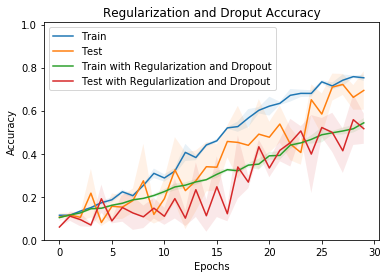

In [97]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_rd, std_acc_rd)
plot_mean_std(mean_acc_val_rd, std_acc_val_rd)
plt.ylim(0, 1.01)
plt.title("Regularization and Droput Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Regularization and Dropout', 'Test with Regularlization and Dropout'], loc='best')

## Exercise 3

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost.

Download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy). If training is too slow you can use a cloud hosted notebook to train using a GPU
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?

In [28]:
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import BatchNormalization
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
from keras.preprocessing.image import ImageDataGenerator
trainGenerator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)
train = trainGenerator.flow_from_directory('../data/MaleFemale/train',
                                      target_size = (64, 64),
                                      batch_size = 64,
                                      class_mode = 'binary')
testGenerator = ImageDataGenerator(rescale = 1./255)
test = testGenerator.flow_from_directory('../data/MaleFemale/test',
                                      target_size = (64, 64),
                                      batch_size = 64,
                                      class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [30]:
model.fit_generator(train, epochs=2, verbose=1, steps_per_epoch=182)

Epoch 1/2
182/182 [==============================] - 90s - loss: 1.7284 - acc: 0.5599    
Epoch 2/2
182/182 [==============================] - 88s - loss: 0.6251 - acc: 0.6623    


In [33]:
from itertools import islice
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_pred = model.predict_classes(X_test).ravel()

3168/3176 [============================>.] - ETA: 0s

In [34]:
np.argwhere(y_test != y_pred).ravel()

array([   1,    4,    5,    6,    9,   19,   24,   29,   30,   33,   34,
         37,   43,   45,   46,   47,   48,   52,   55,   57,   78,   79,
         82,   83,   86,   87,   91,   92,   94,  100,  105,  108,  114,
        116,  117,  121,  123,  124,  125,  126,  128,  130,  134,  136,
        138,  143,  145,  147,  148,  152,  155,  159,  162,  163,  164,
        165,  168,  178,  182,  183,  187,  188,  194,  200,  201,  206,
        209,  212,  214,  215,  216,  217,  219,  220,  226,  233,  235,
        239,  243,  246,  249,  254,  261,  268,  270,  272,  273,  276,
        279,  280,  287,  289,  292,  294,  299,  309,  310,  316,  318,
        321,  327,  329,  330,  331,  334,  336,  337,  340,  344,  345,
        351,  352,  358,  359,  363,  369,  370,  371,  378,  379,  382,
        389,  390,  391,  404,  411,  413,  417,  420,  424,  432,  433,
        434,  435,  436,  438,  444,  445,  447,  448,  450,  452,  455,
        458,  463,  468,  477,  478,  480,  482,  4

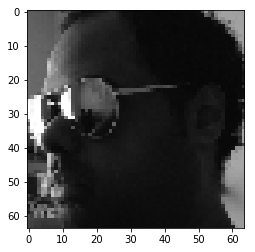

In [36]:
plt.imshow(X_test[19])